In [ ]:
import os

import fastf1
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import  mean_absolute_error
from sklearn.pipeline import Pipeline

In [ ]:
seed: int = 1042
np.random.seed(seed)

In [ ]:
basepath: str = "c:/Users/paulw/OneDrive/Desktop/GitHub/005_Formula_One"
fastf1.Cache.enable_cache(os.path.join(basepath, "data/cache"))

In [ ]:
session_2024 = fastf1.get_session(2024, "JAPAN", "R")
session_2024.load()

In [ ]:
session_2024.laps.columns

In [ ]:
cols = ["Driver", "LapTime", "Sector1Time", "Sector2Time", \
        "Sector3Time", "SpeedI1", "SpeedI2", "Compound", \
        "FreshTyre", "TrackStatus", "Team"]

In [80]:
## Extract lap times and driver names

laps_2024 = session_2024.laps[cols].copy()

In [81]:
laps_2024.dropna(subset="LapTime", inplace=True)
laps_2024.dropna(subset="Sector1Time", inplace=True)
laps_2024.dropna(subset="SpeedI1", inplace=True)

In [82]:
for col in ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]:
    laps_2024[col] = laps_2024[col].dt.total_seconds()

In [83]:
## 2025 Qualifying Data

qualifying_2025 = fastf1.get_session(2025, "JAPAN", "Q")
qualifying_2025.load()

logger      WARNING 	Failed to load schedule from FastF1 backend!
req            INFO 	Using cached data for season_schedule
core           INFO 	Loading data for Japanese Grand Prix - Qualifying [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '81', '16', '63', '12', '6', '44', '23', '87', '10', '55', '14', '30', '22', '27', '5', '

In [84]:
qlaps = qualifying_2025.laps[cols].copy()

In [85]:
qlaps.dropna(subset=["LapTime"], inplace=True)
qlaps.dropna(subset=["Sector1Time"], inplace=True)
qlaps.dropna(subset=["SpeedI1"], inplace=True)

In [86]:
for col in ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]:
    qlaps[col] = qlaps[col].dt.total_seconds()

In [87]:
qlaps['Team'].replace('Racing Bulls', 'RB', inplace=True)

C:\Users\paulw\AppData\Local\Temp\ipykernel_16432\2061996253.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  qlaps['Team'].replace('Racing Bulls', 'RB', inplace=True)


In [88]:
drivers_2024 = set(laps_2024['Driver'])
drivers_2025 = set(qlaps['Driver'])

driver_scores = {driver: 1 if driver in drivers_2024 and driver in drivers_2025 else 0 for driver in drivers_2024.union(drivers_2025)}
driver_scores

{'RUS': 1,
 'BOR': 0,
 'TSU': 1,
 'STR': 1,
 'MAG': 0,
 'ANT': 0,
 'HUL': 1,
 'BEA': 0,
 'PER': 0,
 'GAS': 1,
 'LAW': 0,
 'SAI': 1,
 'OCO': 1,
 'DOO': 0,
 'HAM': 1,
 'PIA': 1,
 'ALO': 1,
 'VER': 1,
 'ALB': 0,
 'LEC': 1,
 'ZHO': 0,
 'NOR': 1,
 'SAR': 0,
 'BOT': 0,
 'HAD': 0}

In [91]:
teams_2024 = set(laps_2024['Team'])
teams_2025 = set(qlaps['Team'])

teams_scores = {team: 1 if team in teams_2024 and team in teams_2025 else 0 for team in teams_2024.union(teams_2025)}
teams_scores

{'Kick Sauber': 1,
 'Williams': 1,
 'RB': 1,
 'Aston Martin': 1,
 'Ferrari': 1,
 'Haas F1 Team': 1,
 'Alpine': 1,
 'McLaren': 1,
 'Mercedes': 1,
 'Red Bull Racing': 1}

In [92]:
laps_2024['Driver_Exp'] = laps_2024['Driver'].map(driver_scores)
qlaps['Driver_Exp'] = qlaps['Driver'].map(driver_scores)

In [93]:
laps_2024['Team_Exp'] = laps_2024['Team'].map(teams_scores)
qlaps['Team_Exp'] = qlaps['Team'].map(teams_scores)

In [94]:
laps_2024['Experience'] = laps_2024['Driver_Exp'] + laps_2024['Team_Exp']
qlaps['Experience'] = qlaps['Driver_Exp'] + qlaps['Team_Exp']

In [95]:
df = pd.merge(laps_2024, qlaps, on="Driver", suffixes=("_2024", "_2025"))
df.head()

,Driver,LapTime_2024,Sector1Time_2024,Sector2Time_2024,Sector3Time_2024,SpeedI1_2024,SpeedI2_2024,Compound_2024,FreshTyre_2024,TrackStatus_2024,...,Sector3Time_2025,SpeedI1_2025,SpeedI2_2025,Compound_2025,FreshTyre_2025,TrackStatus_2025,Team_2025,Driver_Exp_2025,Team_Exp_2025,Experience_2025
0,VER,96.472,34.772,43.042,18.658,278.0,292.0,MEDIUM,False,1,...,17.489,288.0,298.0,SOFT,True,1,Red Bull Racing,1,1,2
1,VER,96.472,34.772,43.042,18.658,278.0,292.0,MEDIUM,False,1,...,26.490,248.0,190.0,SOFT,True,1,Red Bull Racing,1,1,2
2,VER,96.472,34.772,43.042,18.658,278.0,292.0,MEDIUM,False,1,...,17.529,288.0,299.0,SOFT,False,1,Red Bull Racing,1,1,2
3,VER,96.472,34.772,43.042,18.658,278.0,292.0,MEDIUM,False,1,...,23.767,254.0,260.0,SOFT,False,1,Red Bull Racing,1,1,2
4,VER,96.472,34.772,43.042,18.658,278.0,292.0,MEDIUM,False,1,...,17.351,288.0,300.0,SOFT,True,1,Red Bull Racing,1,1,2


In [96]:
if len(df) == 0:
    raise ValueError("No data available for the selected drivers.")

In [97]:
compound_mapping = {'SOFT': 0, 'MEDIUM': 1, 'HARD': 2}
df['Compound_2024'] = df['Compound_2024'].map(compound_mapping)

qlaps['Compound'] = qlaps['Compound'].map(compound_mapping)

In [98]:
df['FreshTyre_2024'] = df['FreshTyre_2024'].astype(int)
qlaps['FreshTyre'] = qlaps['FreshTyre'].astype(int)

In [104]:
X = df[["Sector1Time_2024", "Sector2Time_2024", "Sector3Time_2024", \
            'SpeedI1_2024', 'SpeedI2_2024', "Compound_2024", "FreshTyre_2024", \
            'Driver_Exp_2024', 'Team_Exp_2024', "Experience_2024"]].values
y = df["LapTime_2024"].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

## Build Linear regression

In [105]:
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)

LinearRegression()

In [106]:
linear_regression.score(X_test, y_test)

1.0

In [107]:
predcols = ["Sector1Time", "Sector2Time", "Sector3Time", \
            'SpeedI1', 'SpeedI2', "Compound", "FreshTyre", \
            'Driver_Exp', 'Team_Exp', "Experience"]

In [108]:
qlaps['LapTime_2025_Pred'] = linear_regression.predict(qlaps[predcols].values)

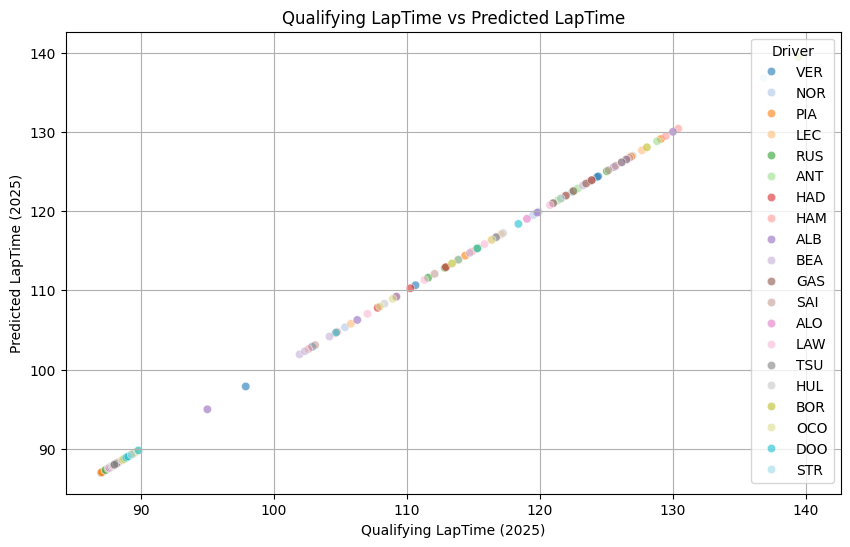

In [109]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=qlaps, x='LapTime', y='LapTime_2025_Pred', hue='Driver', palette='tab20', alpha=0.6)
plt.title('Qualifying LapTime vs Predicted LapTime')
plt.xlabel('Qualifying LapTime (2025)')
plt.ylabel('Predicted LapTime (2025)')
plt.grid(True)
plt.show()

In [110]:
fastest_laps = qlaps.groupby('Driver')['LapTime_2025_Pred'].min().reset_index()
fastest_laps.rename(columns={'LapTime': 'FastestLapTime'}, inplace=True)
fastest_laps

,Driver,LapTime_2025_Pred
0,ALB,87.615
1,ALO,87.897
2,ANT,87.555
3,BEA,87.711
4,BOR,88.622
5,DOO,88.877
6,GAS,87.822
7,HAD,87.569
8,HAM,87.610
9,HUL,88.570


In [111]:
# Sort the fastest laps by predicted lap time
fastest_laps_sorted = fastest_laps.sort_values(by="LapTime_2025_Pred", ascending=True)

# Predict the winner (driver with the fastest lap)
predicted_winner = fastest_laps_sorted.iloc[0]["Driver"]

print(f"Predicted Winner: {predicted_winner}")
fastest_laps_sorted

Predicted Winner: VER


,Driver,LapTime_2025_Pred
19,VER,86.983
12,NOR,86.995
14,PIA,87.027
11,LEC,87.299
15,RUS,87.318
2,ANT,87.555
7,HAD,87.569
8,HAM,87.610
0,ALB,87.615
3,BEA,87.711


In [112]:
mean_absolute_error(y_test, linear_regression.predict(X_test))

9.312504093415923e-14

Let's move to a more complicated model

In [113]:
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=seed)
gb.fit(X_train, y_train)

c:\Users\paulw\OneDrive\Desktop\GitHub\005_Formula_One\.venv\Lib\site-packages\sklearn\ensemble\_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


GradientBoostingRegressor(random_state=1042)

In [114]:
gb.score(X_test, y_test)

0.9998791005799834

In [115]:
qlaps['LapTime_2025_Pred_GB'] = gb.predict(qlaps[predcols].values)

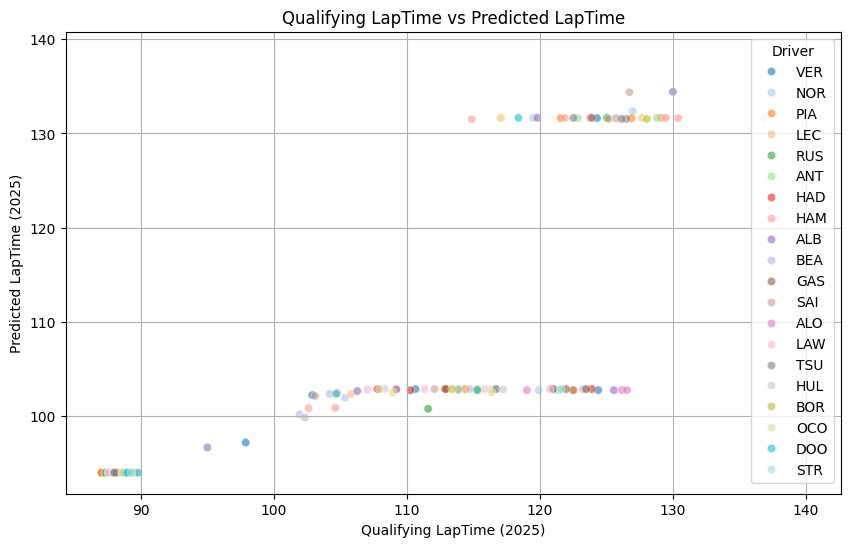

In [116]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=qlaps, x='LapTime', y='LapTime_2025_Pred_GB', hue='Driver', palette='tab20', alpha=0.6)
plt.title('Qualifying LapTime vs Predicted LapTime')
plt.xlabel('Qualifying LapTime (2025)')
plt.ylabel('Predicted LapTime (2025)')
plt.grid(True)
plt.show()

In [119]:
fastest_laps = qlaps.groupby('Driver')['LapTime_2025_Pred_GB'].min().reset_index()
fastest_laps.rename(columns={'LapTime': 'FastestLapTime'}, inplace=True)
fastest_laps

,Driver,LapTime_2025_Pred_GB
0,ALB,93.932497
1,ALO,93.932497
2,ANT,93.932497
3,BEA,93.932497
4,BOR,93.932497
5,DOO,93.932497
6,GAS,93.932497
7,HAD,93.932497
8,HAM,93.932497
9,HUL,93.932497


In [120]:
# Sort the fastest laps by predicted lap time
fastest_laps_sorted = fastest_laps.sort_values(by="LapTime_2025_Pred_GB", ascending=True)

# Predict the winner (driver with the fastest lap)
predicted_winner = fastest_laps_sorted.iloc[0]["Driver"]

print(f"Predicted Winner: {predicted_winner}")
fastest_laps_sorted

Predicted Winner: ALB


,Driver,LapTime_2025_Pred_GB
0,ALB,93.932497
1,ALO,93.932497
2,ANT,93.932497
3,BEA,93.932497
4,BOR,93.932497
5,DOO,93.932497
6,GAS,93.932497
7,HAD,93.932497
8,HAM,93.932497
9,HUL,93.932497


In [121]:
mean_absolute_error(y_test, gb.predict(X_test))

0.046824571999473305